<a href="https://colab.research.google.com/github/OctavioPescador/Evaluating-the-Impact-of-Leak-Rate-in-Parallel-Reservoir-Echo-State-Networks/blob/main/AM_170B_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.integrate import solve_ivp
# in rossler
import os
# in ks
from matplotlib import cm
from scipy.fft import fft, ifft

from matplotlib.colors import TwoSlopeNorm

plt.rcParams['figure.facecolor'] = 'white'

# System Functions

In [ ]:
def generate_lorenz_data(t_train, t_pred, t0, tf, s, r, b, ic=[1.0,1.0,1.0]):
    def lorenz(t, state):
        x, y, z = state
        dxdt = s * (y - x)
        dydt = x * (r - z) - y
        dzdt = x * y - b * z
        return [dxdt, dydt, dzdt]

    dt = (tf-t0)/t_train
    t_span = (t0, t0 + (t_train + t_pred)*dt)
    t_eval = np.linspace(t_span[0], t_span[1], t_train + t_pred)  # times to save the solution

    sol = solve_ivp(lorenz, t_span, ic, t_eval=t_eval, method='RK45')

    x, y, z = sol.y
    t = sol.t
    U = np.vstack((x, y, z))  # shape lorenz data set to: (3, timesteps)
    return U

In [ ]:
# Rössler System
def generate_rossler_data(t_train, t_pred, t0, tf, a, b, c, ic=[0.1,0.1,0.1], save_path='rossler_data.npy'):
    """Generate Rössler attractor data with guaranteed chaos"""
    def rossler_equations(t, state, aa=a, bb=b, cc=c):
        x, y, z = state
        return [-y - z, x + aa*y, bb + z*(x - cc)]

    dt = (tf-t0)/t_train
    t_span = (t0, t0 + (t_train + t_pred)*dt)
    t_eval = np.linspace(t_span[0], t_span[1], t_train + t_pred)
    sol = solve_ivp(rossler_equations, t_span, ic,
                   t_eval=t_eval, method='RK45', rtol=1e-6)

    data = sol.y.T  # Shape: (time_steps, 3)
    np.save(save_path, data)
    return sol.t, data

def plot_rossler_data(t, data, title="Rössler Attractor"):
    fig = plt.figure()
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.plot(data[:,0], data[:,1], data[:,2], lw=0.5)
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
    if np.max(data) < 1e-3:
        print("Warning: Rössler data is abnormally small!")
    else:
        plt.show()
    # # Time Series
    # ax2 = fig.add_subplot(122)
    # labels = ['X', 'Y', 'Z']
    # for i in range(3):
    #     ax2.plot(t, data[:,i], label=labels[i])
    # ax2.legend(); ax2.set_xlabel('Time')
    # plt.suptitle(title)
    return

In [ ]:
class KuramotoSivashinsky:
    # - ETDRK4 time-stepping method for efficient integration

    # N (int): Number of spatial grid point
    # mu (float): Inhomogeneity strength (μ in the equation)
    # lam (float): Inhomogeneity wavelength (λ in the equation)
    def __init__(self, t_train, t_pred, t0, tf, N=1024, L=32*np.pi, mu=0.0, lam=100):
        # L (float): System length (periodic domain [0,L])
        # h (float): Time step size
        # tmax (float): Maximum simulation time

        self.N = N; self.L = L

        self.mu = mu; self.lam = lam

        self.t_train = t_train
        self.t_pred = t_pred

        self.h = (tf-t0)/t_train # dt
        self.tmax = (t_train + t_pred - 1) * self.h

        # Spatial grid
        self.x = np.linspace(0, L, N, endpoint=False)
        # Fourier wave numbers
        self.k = 2*np.pi*np.fft.fftfreq(N, d=L/N)
        # Linear operator in Fourier space
        self.L_hat = self.k**2 - self.k**4
        # ETDRK4 scheme coefficients
        self._setup_etdrk4()

    def _setup_etdrk4(self, M=16):
        """Set up ETDRK4 coefficients"""
        r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5)/M)
        LR = self.h * np.outer(self.L_hat, np.ones(M)) + r

        self.Q = self.h * np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
        self.f1 = self.h * np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
        self.f2 = self.h * np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
        self.f3 = self.h * np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))

        self.E = np.exp(self.h*self.L_hat)
        self.E2 = np.exp(self.h*self.L_hat/2)

    def nonlinear_term(self, v):
        """Compute nonlinear term in Fourier space"""
        u = np.real(ifft(v))
        return -0.5j * self.k * fft(u**2)

    def inhomogeneous_term(self):
        """Compute the μcos(2πx/λ) term if μ != 0"""
        if self.mu == 0:
            return 0
        return self.mu * np.cos(2*np.pi*self.x/self.lam)

    def solve(self, u0=None):
        if u0 is None:
            u0 = np.cos(2*np.pi*self.x/self.L)*(1 + np.sin(2*np.pi*self.x/self.L))

        v = fft(u0)

        # Storage for the solution
        nsteps = int(self.tmax/self.h)
        nplt = 1  # Save 100 time points
        uu = [u0]
        tt = [0]

        # th main time-stepping loop
        for n in range(1, nsteps+1):
            t = n*self.h

            Nv = self.nonlinear_term(v) + fft(self.inhomogeneous_term())

            a = self.E2*v + self.Q*Nv
            Na = self.nonlinear_term(a) + fft(self.inhomogeneous_term())

            b = self.E2*v + self.Q*Na
            Nb = self.nonlinear_term(b) + fft(self.inhomogeneous_term())

            c = self.E2*a + self.Q*(2*Nb - Nv)
            Nc = self.nonlinear_term(c) + fft(self.inhomogeneous_term())

            v = self.E*v + Nv*self.f1 + 2*(Na + Nb)*self.f2 + Nc*self.f3

            if n % nplt == 0:
                u = np.real(ifft(v))
                uu.append(u)
                tt.append(t)

        return np.array(tt), np.array(uu)

    def save_training_data(self, filename, uu, tt):
        np.savez(filename, u=uu, t=tt, x=self.x,
                 params={'N':self.N, 'L':self.L, 'h':self.h,
                 'tmax':self.tmax, 'mu':self.mu, 'lam':self.lam})

    def plot_solution(self, tt, uu, plot_type='2d'):
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        im0 = axs[0].imshow(
            uu.T,
            extent=[tt[0], tt[-1], self.x[0], self.x[-1]],
            aspect='auto',
            origin='lower',
            cmap='berlin'
        )
        axs[0].set_title('Full Solution')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Space (x)')
        axs[0].axvline(x=tt[self.t_train], color='white', linestyle='--', linewidth=2, label='Train/Test Split')
        axs[0].legend()
        fig.colorbar(im0, ax=axs[0], label='u(x,t)')

        im1 = axs[1].imshow(
            uu.T[:, self.t_train:],  # only prediction region
            extent=[tt[self.t_train], tt[-1], self.x[0], self.x[-1]],
            aspect='auto',
            origin='lower',
            cmap='berlin'
        )
        axs[1].set_title('Prediction Region')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Space (x)')
        fig.colorbar(im1, ax=axs[1], label='u(x,t)')
        plt.tight_layout()
        # plt.show()
        plt.show(block=False)

# ESN Functions

In [ ]:
def calculate_Idim(Ishape):
    dim = -1
    for i in range(len(Ishape)):
        if Ishape[i] != 1:
            dim += 1
    # print("\n%dD Input matrix shape:" % (dim), Ishape)
    return dim

In [ ]:
def rc_Din_pSize(Ishape, Idim, pNum, Dr, o):
    pSize = [0,0,0]
    if (pNum[0]==1):
        pSize[0] = Ishape[0]/pNum[0]
        rc = pNum[0]
        Din = pSize[0]
    else:
        if (Idim >= 1):
            pSize[0] = Ishape[0]/pNum[0]
            if (pSize[0] != int(pSize[0])):
                print("Uneven row partitioning")
                exit()
            else:
                rc = pNum[0]
                Din = pSize[0] + 2*o
        if (Idim >= 2):
            pSize[1] = Ishape[1] / pNum[1]
            if (pSize[1] != int(pSize[1])):
                print("Uneven col partitioning")
                exit()
            else:
                rc = rc*pNum[1]
                Din = Din * (pSize[1] + 2 * o)
        if (Idim >= 3):
            pSize[2] = Ishape[2] / pNum[2]
            if (pSize[2] != int(pSize[2])):
                print("Uneven depth partitioning")
                exit()
            else:
                rc = rc*pNum[2]
                Din = Din * (pSize[2] + 2 * o)
    rc = int(rc)
    Din = int(Din)
    # print("\nThis results in %d reservoirs with:\n" \
    #     "    reservoir size: %d\n" \
    #     "    reservoir o: %d\n" \
    #     "    reservoir input size: %d+(%d)" \
    #     % (rc, Dr, o, Din-2*o, 2*o))
    return rc, Din, pSize

In [ ]:
def A_init(Dr, deg, rc, eMax):
    sparsity = deg/Dr
    A = np.zeros((Dr, Dr, rc))
    for rr in range(rc):
        A[:,:,rr] = sparse.rand(Dr, Dr, density=sparsity).toarray()
    for rr in range(rc):
        max_eigenvalue = max(abs(np.linalg.eigvals(A[:,:,rr])))
        A[:,:,rr] = A[:,:,rr] * (eMax/max_eigenvalue)
    # print("\nThe adjacency matrix shape is:", A.shape)
    # print("with a set max eigenvalue of:", eMax)
    return A

In [ ]:
def R_init(t_train, Dr, rc):
    R = np.zeros((int(Dr), 1, int(rc), t_train))
    # print("\nThe reservoir states shape is:", R.shape)
    return R

In [ ]:
def Win_init(Dr, Din, rc, Win_range):
    Win = (np.random.rand(Dr, Din, rc)*2 -1) * Win_range
    # print("\nThe input weight shape is:", Win.shape)
    return Win

In [ ]:
def pad_I(I, Idim, pNum, o):
    if (pNum[0] != 1):
    # pad each dimension of the input up to the input's dimension with zeros of 'overlap' thickness
        if (Idim >= 1):
            I = np.pad(I, pad_width=((o,o),(0,0),(0,0)), mode='constant', constant_values=0)
        if (Idim >= 2):
            I = np.pad(I, pad_width=((0,0),(o,o),(0,0)), mode='constant', constant_values=0)
        if (Idim >= 3):
            I = np.pad(I, pad_width=((0,0),(0,0),(o,o),(0,0)), mode='constant', constant_values=0)
    return I

In [ ]:
def part_I(t_train, I, D, Din, r_count, pNum, pSize, o):
    inputs_r = np.zeros((Din, 1, r_count, t_train))
    for tt in range(t_train-1):
        for rr in range(int(pNum[0])):
            row_start = rr*int(pSize[0])
            row_end = row_start + int(pSize[0] + 2*o)
            if D == 1:
                # print(tt, rc, row_start, row_end)
                inputs_r[:, 0, rr, tt] = I[row_start:row_end, 0, tt]
                continue
            for cc in range(int(pNum[1])):
                col_start = cc*int(pSize[1] )
                col_end = col_start + int(pSize[1] + 2*o)
                if D == 2:
                    inputs_r[:, 0, rr, tt] = I[row_start:row_end, col_start:col_end, tt].flatten()
                    continue
                for dd in range(int(pNum[2])):
                    depth_start = dd*int(pSize[2] )
                    depth_end = depth_start + int(pSize[2] + 2*o)
                    if D == 3:
                        inputs_r[:, 0, rr, tt] = I[row_start:row_end, col_start:col_end, depth_start:depth_end, tt].flatten()
    return inputs_r

In [ ]:
def reservoir_training(A, r, W, h, t, rc, l):
    next_r = np.zeros((r.shape[0], 1, rc))
    # for each reservoir, update using the current r(t) and input_partition(t), no leaky integrator implemented yet
    for i in range(rc):
        next_r[:,:,i] = (1-l)*r[:,:,i,t] + l*np.tanh(A[:,:,i] @ r[:,:,i,t] + W[:,:,i] @ h[:,:,i])
    return next_r

In [ ]:
def Wout_solve(t_train, I, pNum, R, Dr, Din, rc, o, b):
    if (pNum[0] == 1):
        data_size = Din
    else:
        data_size = int(Din - o*2)
    Wout = np.zeros((data_size, Dr*2, rc))

    for rr in range (rc):
        Rstack = np.vstack((R[:,0,rr,1:], (R[:,0,rr,1:]**2)))
        RstackT = Rstack.T

        if (rc == 1):
            target_partition = I[:,0,1:t_train]
        else:
            target_partition = I[o+rr*data_size:o+(rr+1)*data_size, 0, 1:t_train]

        identity = np.eye(Rstack.shape[0])
        Wout[:,:,rr] = target_partition @ RstackT @ np.linalg.inv(Rstack @ RstackT + b * identity)

    Wout1 = Wout[:, :Dr, :]
    Wout2 = Wout[:, Dr:, :]
    # print ("\nOutput weight shapes for linear and nonlinear features are:", Wout1.shape)
    return Wout1, Wout2, data_size

In [ ]:
def train_and_calculate(T_t, T_p, I, Dr, deg, leak, pNum, eMax, Win_R, o, b):
    Ishape = I.shape
    Isize = Ishape[0]
    Idim = calculate_Idim(Ishape)

    rc, Din, pSize = rc_Din_pSize(Ishape, Idim, pNum, Dr, o)
    A = A_init(Dr, deg, rc, eMax)
    R = R_init(T_t, Dr, rc)
    Win = Win_init(Dr, Din, rc, Win_R)

    I = pad_I(I, Idim, pNum, o)
    R_in = part_I(T_t, I, Idim, Din, rc, pNum, pSize, o)
    for t in range(T_t-1):
        R[:,:,:,t+1] = reservoir_training(A, R, Win, R_in[:,:,:,t], t, rc, leak)

    Wout1, Wout2, dSize = Wout_solve(T_t, I, pNum, R, Dr, Din, rc, o, b)
    return Idim, Isize, dSize, pSize, Win, A, R, Din, rc, Wout1, Wout2

In [ ]:
def predict(t_pred, Idim, Isize, data_size, pNum, pSize, Win, A, R_trained, Dr, Din, rc, o, leak, Wout1, Wout2):
    preds = np.zeros((Isize, 1, t_pred))
    R_preds = np.zeros((Dr, 1, rc, t_pred+1))
    R_preds[:,:,:,0] = R_trained[:,:,:,-1]

    # print("\nEach reservoir predicts", data_size, "value(s) with", rc, "total reservoirs"\
    #   "\nfor a total of", t_pred, "timesteps.",\
    #   "\n    new updated reservoirs stored in a matrix of shape:", R_preds.shape,\
    #   "\n    and  new predicted  values in  a matrix  of shape: ", preds.shape)

    for tt in range(t_pred):
        if (pNum[0] == 1):
            preds[:,:,tt] = Wout1[:,:,0] @ R_preds[:,:,0,tt] + Wout2[:,:,0] @ (R_preds[:,:,0,tt]**2)
        else:
            for rr in range(rc):
                preds[rr*data_size:(rr+1)*data_size,:,tt] = Wout1[:,:,rr] @ R_preds[:,:,rr,tt] + Wout2[:,:,rr] @ (R_preds[:,:,rr,tt]**2)

        pred = preds[:,:,tt].reshape(Isize,1,1)
        pred = pad_I(pred, Idim, pNum, o)

        Rin = part_I(2, pred, Idim, Din, rc, pNum, pSize, o)

        R_preds[:,:,:,tt+1] = reservoir_training(A, R_preds, Win, Rin[:,:,:,0], tt, rc, leak)
    return preds, R_preds

# Plotting Functions

In [ ]:
def plot_abs_error(diff):
    abs_diff = abs(diff)
    abs_diff_sum = abs_diff.sum(axis=0)

    plt.figure(figsize=(10, 4))
    plt.plot(abs_diff_sum, color='red')
    plt.xlabel("Timestep"); plt.ylabel("Absolute Error")
    plt.title("Absolute Error Over Time")
    plt.show()
    return

In [ ]:
def plot_rmse(diff, true):
    rmse = np.sqrt(np.mean(diff**2, axis=0))
    std = np.std(true, axis=0)
    nrmse = rmse / (std + 1e-8)

    # === Plot ===
    plt.figure(figsize=(10, 4))
    plt.plot(nrmse, lw=2, label='NRMSE (per timestep σ)')
    plt.xlabel("Timestep"); plt.ylabel("NRMSE")
    plt.title("Normalized RMSE Over Time of Predictions")
    plt.show()
    return

In [ ]:
def plot_decorrelation(R, t0):
    Dr, _, rc, T = R[:,:,:,t0:] .shape
    deCor = np.zeros((T))

    plt.figure(figsize=(10, 4))
    for r in range(rc):
        r0      = R[:,0,r,t0].flatten()
        r0_norm = np.linalg.norm(r0)
        stop = 0
        for t in range(T):
            rt = R[:,0,r,t0+t].flatten()
            rt_norm = np.linalg.norm(rt)
            deCor[t] = np.dot(r0, rt) / (r0_norm * rt_norm + 1e-8)
            if deCor[t] <= 0:
                stop = 1
                break
        if stop:
            plt.plot(deCor[:t], label=f"Reservoir {r}")
            continue
        else:
            plt.plot(deCor, label=f"Reservoir {r}")

    plt.xlabel("Timestep")
    plt.ylabel("Cosine Similarity with Initial State")
    plt.title("Reservoir State Decorrelation Over Time")
    plt.legend(loc='upper right')
    plt.grid(True); plt.tight_layout()
    plt.show()
    return

In [ ]:
def plot_data_decorrelation(data, t0):
    T, D = data.shape
    deCor = np.zeros(T - t0)

    d0 = data[t0, :].flatten()
    d0_norm = np.linalg.norm(d0)

    stop = 0
    for t in range(T - t0):
        dt = data[t0 + t, :].flatten()
        dt_norm = np.linalg.norm(dt)
        deCor[t] = np.dot(d0, dt) / (d0_norm * dt_norm + 1e-8)
        if deCor[t] <= 0:
            stop = t
            break

    plt.figure(figsize=(10, 4))
    plt.plot(deCor[:stop])

    plt.xlabel("Timestep"); plt.ylabel("Cosine Similarity with Initial State")
    plt.title("System Decorrelation Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return stop

# Figure Analysis (Lorenz)

In [ ]:
# Lorenz system parameters
training_time_L = 10000
prediction_time_L = 250
t0_L = 0; tf_L = 40

sigma = 10; rho = 28; beta = 8/3
lorenz_ic = [1.0, 1.0, 1.0]

# ESN Parameters
degree     = 3
leaky_rate = 1
# - - - - - - - - [R  C  D]
partitions_L      = [3, 0, 0]
reservoir_size_L  = 100
overlap_L = 2;

# DON'T CHANGE
enforced_max_eigenvalue = .58; input_weight_range = .01; ridge_beta = 0.0001

# Input Data Generation
lorenz_data = generate_lorenz_data(training_time_L, prediction_time_L, t0_L, tf_L, sigma, rho, beta, lorenz_ic)
input_L = lorenz_data[:, np.newaxis, :-1] # (3, 1, timesteps)

In [ ]:
# Setup, Training, Calculating
input_dimension, input_size,           data_size,          \
partition_sizes, input_weight,         adjacency_matrix,   \
reservoirs,      reservoir_input_size, reservoir_count,    \
output_weight_1, output_weight_2                           \
=                                                          \
train_and_calculate(training_time_L, prediction_time_L, input_L, \
                  reservoir_size_L, degree, leaky_rate,      \
                  partitions_L, enforced_max_eigenvalue,     \
                  input_weight_range, overlap_L, ridge_beta)

# Prediction
predictions_L, prediction_reservoirs_L = predict(prediction_time_L, input_dimension,     \
                                             input_size, data_size, partitions_L,    \
                                             partition_sizes, input_weight,        \
                                             adjacency_matrix, reservoirs,         \
                                             reservoir_size_L, reservoir_input_size, \
                                             reservoir_count, overlap_L, leaky_rate, \
                                             output_weight_1, output_weight_2)

combined_reservoirs_L = np.concatenate((reservoirs[:,:,:,:], prediction_reservoirs_L[:,:,:,1:]), axis=3)

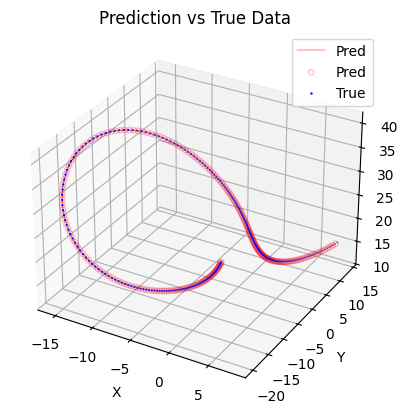

In [ ]:
# TRUTH VS PREDICTION PLOT
pred_L = predictions_L[:,0,:]
true_L = lorenz_data[:,training_time_L-1:-1]
diff_L = pred_L-true_L

x_P = pred_L[0, :]; y_P = pred_L[1, :]; z_P = pred_L[2, :]
x_T = true_L[0, :]; y_T = true_L[1, :]; z_T = true_L[2, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_P, y_P, z_P, linewidth=.35, linestyle='-', color='red', label='Pred')
ax.scatter(x_P, y_P, z_P, s=15, color='red', label='Pred', facecolors='none', marker='o',alpha=.25)
# ax.plot(x_T, y_T, z_T, linewidth=1,  linestyle='-',color='blue', label='True')
ax.scatter(x_T, y_T, z_T, s=.5, color='blue', label='True')

ax.legend(); ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Prediction vs True Data')
plt.show()

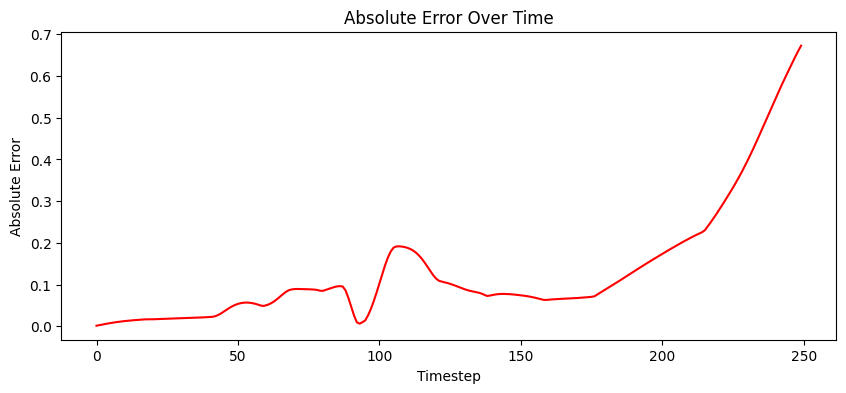

In [ ]:
plot_abs_error(diff_L)

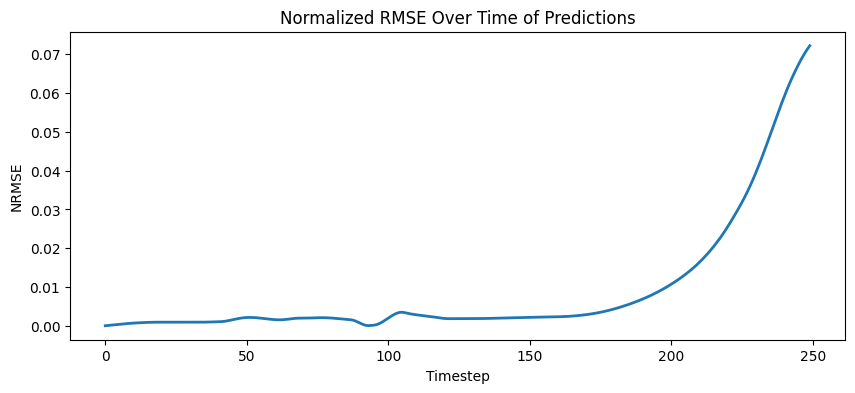

In [ ]:
plot_rmse(diff_L, true_L)

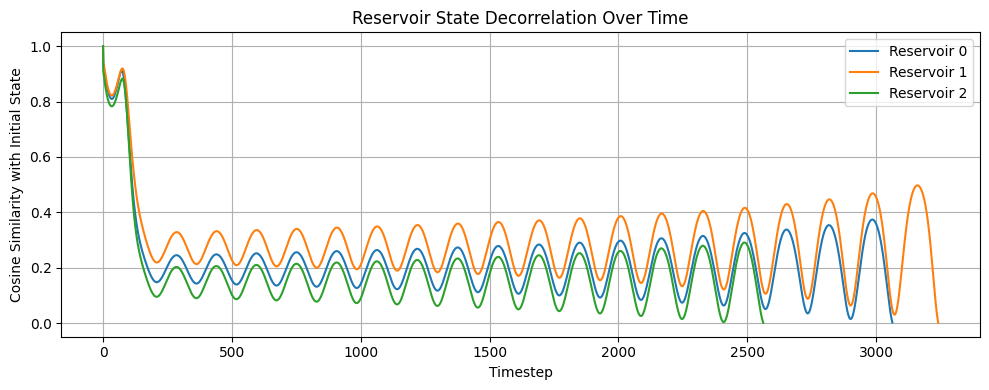

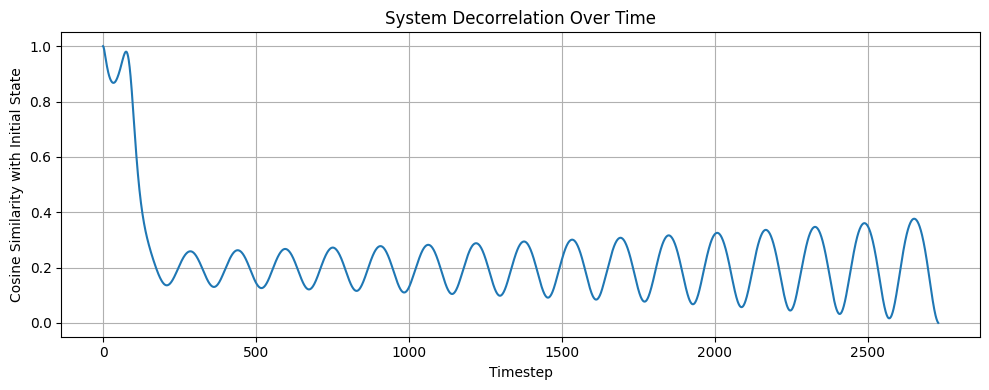

2732

In [ ]:
plot_decorrelation(combined_reservoirs_L, 1)
plot_data_decorrelation(lorenz_data.T, 0)

# Rossler Training and Prediction

In [ ]:
# Rossler system parameters
training_time_R = 20000
prediction_time_R = 250
t0_R = 0; tf_R = 500

a = 0.2; b = 0.2; c = 5.7
rossler_ic = [0.1, 0.1, 0.1]

# ESN Parameters
degree     = 3
leaky_rate = .1
# - - - - - - - - [R  C  D]
partitions_R      = [3, 0, 0]
reservoir_size_R  = 200
overlap_R = 2;

# DON'T CHANGE
enforced_max_eigenvalue = .58; input_weight_range = .01; ridge_beta = 0.0001

# Rossler Data Generation
rossler_t, rossler_data = generate_rossler_data(training_time_R, prediction_time_R, t0_R, tf_R, a, b, c, rossler_ic)
# plot_rossler_data(rossler_t, rossler_data)

input_R = rossler_data.T[:,np.newaxis,:-1]
# print(tt.shape, rossler_data.shape, input.shape)

In [ ]:
# Setup, Training, Calculating
input_dimension, input_size,           data_size,          \
partition_sizes, input_weight,         adjacency_matrix,   \
reservoirs,      reservoir_input_size, reservoir_count,    \
output_weight_1, output_weight_2                           \
=                                                          \
train_and_calculate(training_time_R, prediction_time_R, input_R, \
                  reservoir_size_R, degree, leaky_rate,      \
                  partitions_R, enforced_max_eigenvalue,     \
                  input_weight_range, overlap_R, ridge_beta)

# Prediction
predictions_R, prediction_reservoirs_R = predict(prediction_time_R, input_dimension,     \
                                             input_size, data_size, partitions_R,    \
                                             partition_sizes, input_weight,        \
                                             adjacency_matrix, reservoirs,         \
                                             reservoir_size_R, reservoir_input_size, \
                                             reservoir_count, overlap_R, leaky_rate, \
                                             output_weight_1, output_weight_2)

combined_reservoirs_R = np.concatenate((reservoirs[:,:,:,:], prediction_reservoirs_R[:,:,:,1:]), axis=3)

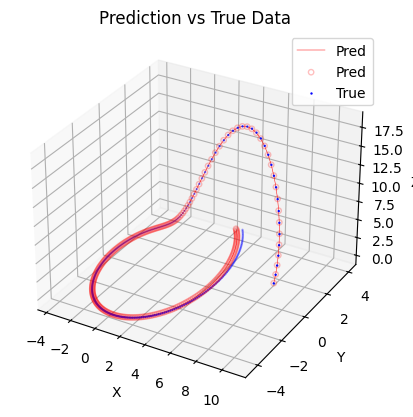

In [ ]:
# plot_rossler_data(rossler_t, rossler_data)
# TRUTH VS PREDICTION PLOT
pred_R = predictions_R[:,0,:]
true_R = rossler_data.T[:,training_time_R-1:-1]
diff_R = pred_R-true_R

x_P = pred_R[0, :]; y_P = pred_R[1, :]; z_P = pred_R[2, :]
x_T = true_R[0, :]; y_T = true_R[1, :]; z_T = true_R[2, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_P, y_P, z_P, linewidth=.35, linestyle='-', color='red', label='Pred')
ax.scatter(x_P, y_P, z_P, s=15, color='red', label='Pred', facecolors='none', marker='o',alpha=.25)
# ax.plot(x_T, y_T, z_T, linewidth=1,  linestyle='-',color='blue', label='True')
ax.scatter(x_T, y_T, z_T, s=.5, color='blue', label='True')

ax.legend(); ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.set_title('Prediction vs True Data')
plt.show()

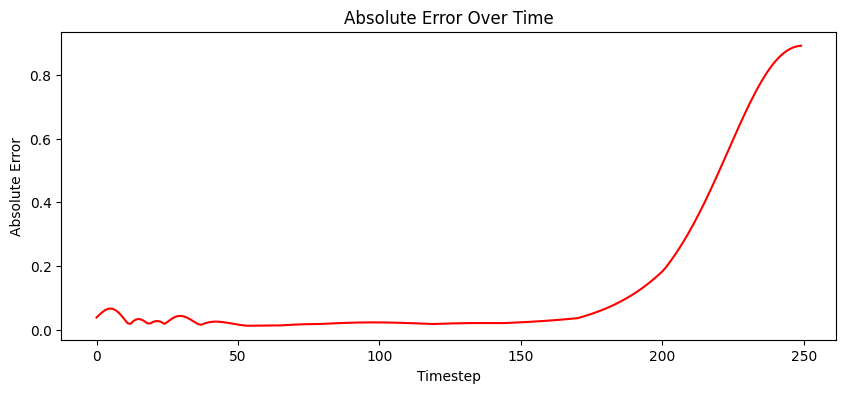

In [ ]:
plot_abs_error(diff_R)

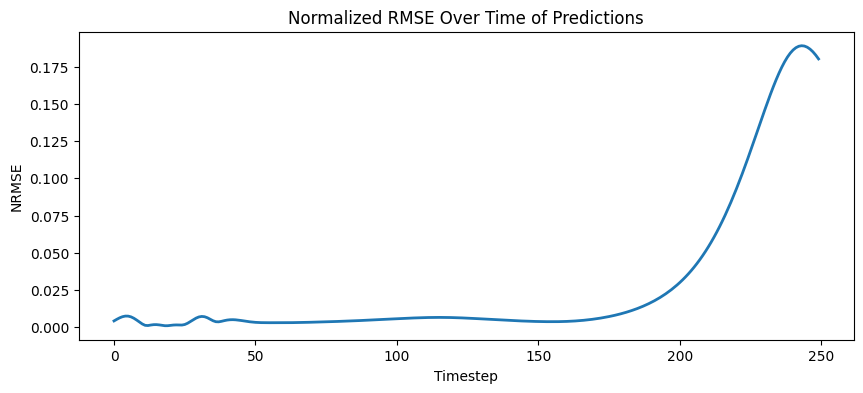

In [ ]:
plot_rmse(diff_R, true_R)

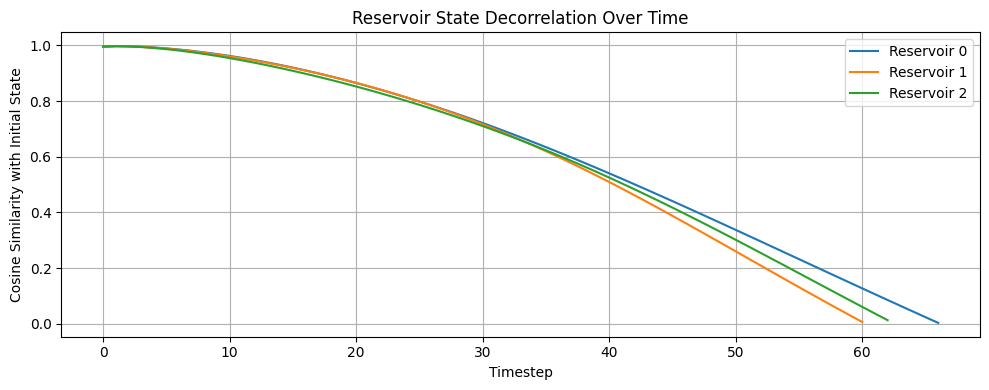

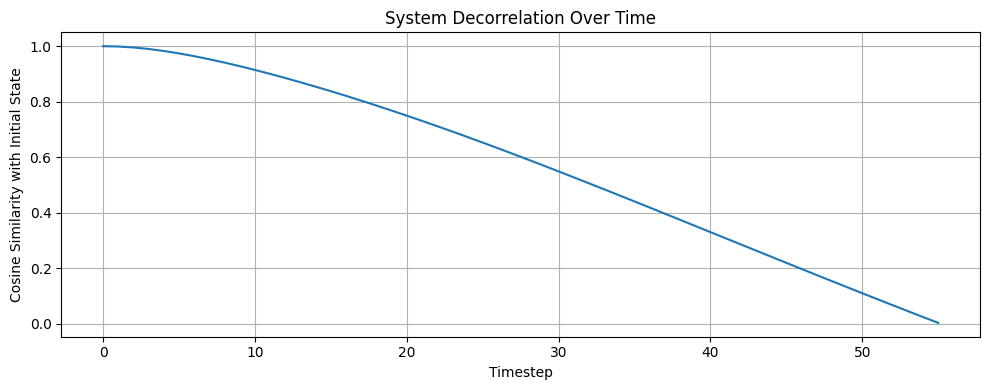

56

In [ ]:
plot_decorrelation(combined_reservoirs_R, 1)
plot_data_decorrelation(rossler_data, 0)

# KS Training and Prediction

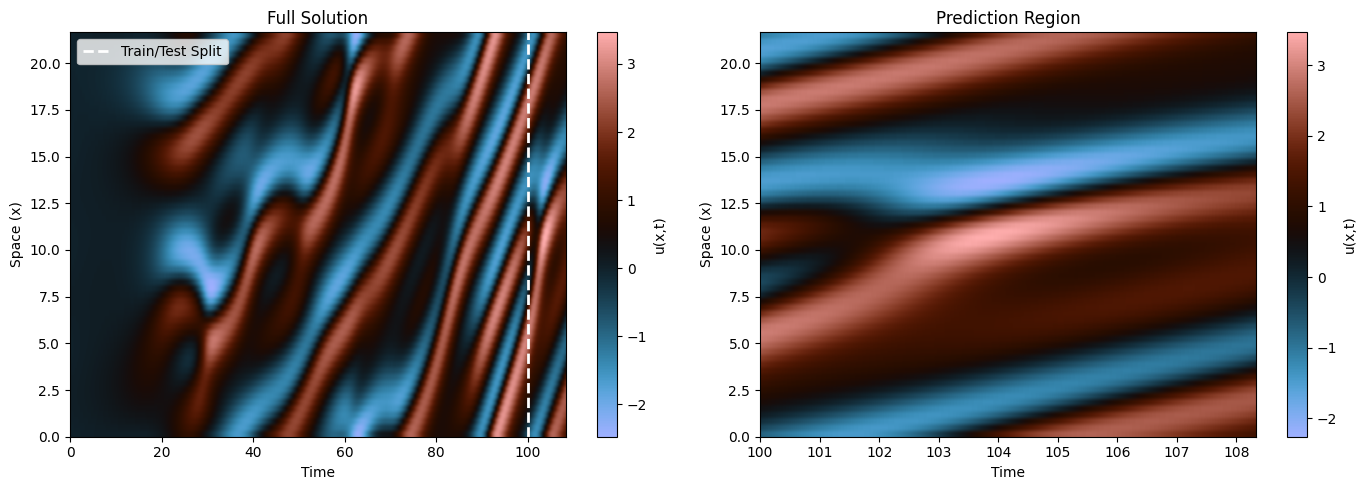

In [ ]:
# KS system parameters
training_time_KS = 30000
prediction_time_KS = 2500
t0_KS = 0; tf_KS = 100
# X_partitions   X_length
N = 64;           L = 22

# ESN Parameters
degree     = 3
leaky_rate = 1
# - - - - - - - - [R  C  D]
partitions_KS      = [8, 0, 0]
reservoir_size_KS  = 500
overlap_KS = 4

# DON'T CHANGE
enforced_max_eigenvalue = .58; input_weight_range = .01; ridge_beta = 0.0001

# KS Data Generation
ks = KuramotoSivashinsky(training_time_KS, prediction_time_KS, t0_KS, tf_KS, N, L, mu=.01, lam=100)

# KS ic
np.random.seed(0)
u0 = .1 * (2 * np.random.rand(ks.N) - 1)

tt_KS, KS_data = ks.solve(u0)
ks.plot_solution(tt_KS, KS_data, plot_type='2d')

input_KS = KS_data.T[:,np.newaxis,:-1]
if input_KS.shape[2] >= training_time_KS+prediction_time_KS:
    prediction_time_KS = prediction_time_KS +1
# print(tt_KS.shape, KS_data.shape, input_KS.shape)

In [ ]:
# Setup, Training, Calculating
input_dimension, input_size,           data_size,          \
partition_sizes, input_weight,         adjacency_matrix,   \
reservoirs,      reservoir_input_size, reservoir_count,    \
output_weight_1, output_weight_2                           \
=                                                          \
train_and_calculate(training_time_KS, prediction_time_KS, input_KS, \
                  reservoir_size_KS, degree, leaky_rate,      \
                  partitions_KS, enforced_max_eigenvalue,     \
                  input_weight_range, overlap_KS, ridge_beta)
# Prediction
predictions_KS, prediction_reservoirs_KS = predict(prediction_time_KS, input_dimension,     \
                                             input_size, data_size, partitions_KS,    \
                                             partition_sizes, input_weight,        \
                                             adjacency_matrix, reservoirs,         \
                                             reservoir_size_KS, reservoir_input_size, \
                                             reservoir_count, overlap_KS, leaky_rate, \
                                             output_weight_1, output_weight_2)

combined_reservoirs_KS = np.concatenate((reservoirs[:,:,:,:], prediction_reservoirs_KS[:,:,:,1:]), axis=3)

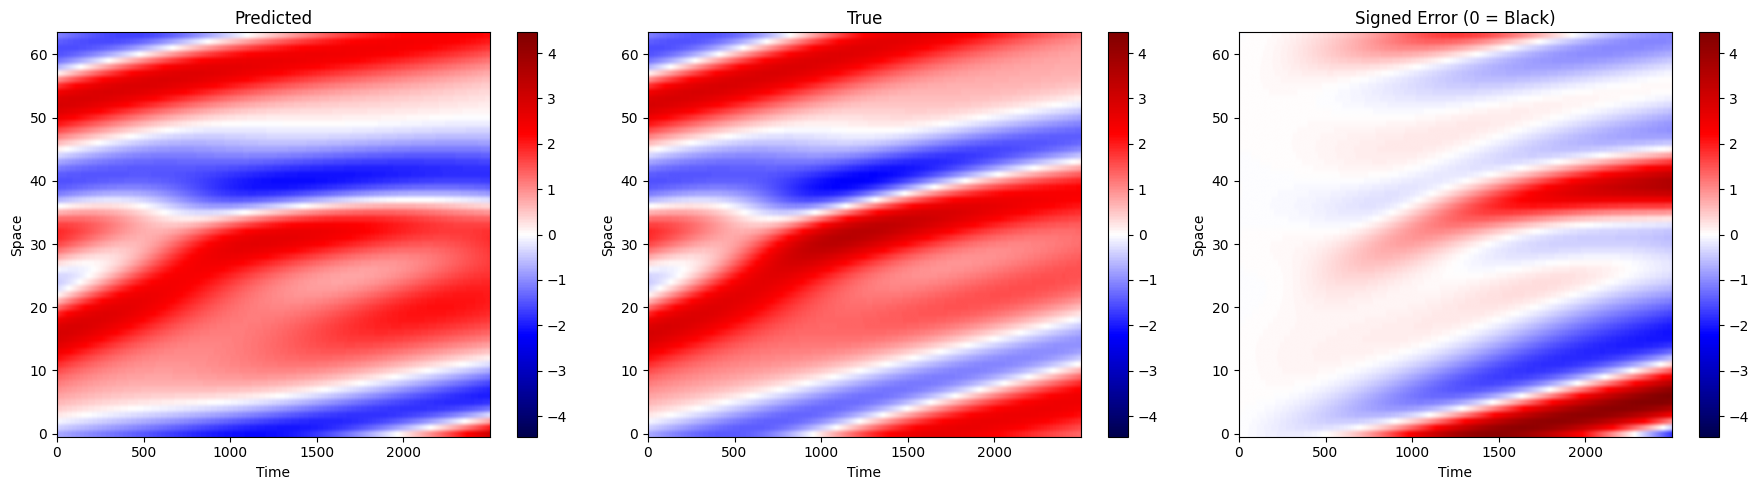

In [ ]:
# Get signed difference
pred_KS = predictions_KS[:, 0, :]
true_KS = KS_data.T[:, training_time_KS-1:-1]
diff_KS = true_KS - pred_KS # signed error

# Compute the max absolute value for symmetric scaling
max_val = np.max(np.abs([pred_KS, true_KS, diff_KS]))

# Create a TwoSlopeNorm centered at 0
norm = TwoSlopeNorm(vmin=-max_val, vcenter=0, vmax=max_val)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Predicted
im0 = axs[0].imshow(pred_KS, aspect='auto', origin='lower', cmap='seismic', norm=norm)
axs[0].set_title('Predicted')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Space')
fig.colorbar(im0, ax=axs[0])

# True
im1 = axs[1].imshow(true_KS, aspect='auto', origin='lower', cmap='seismic', norm=norm)
axs[1].set_title('True')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Space')
fig.colorbar(im1, ax=axs[1])

# Signed Error (centered at 0)
im2 = axs[2].imshow(diff_KS, aspect='auto', origin='lower', cmap='seismic', norm=norm)
axs[2].set_title('Signed Error (0 = Black)')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Space')
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()


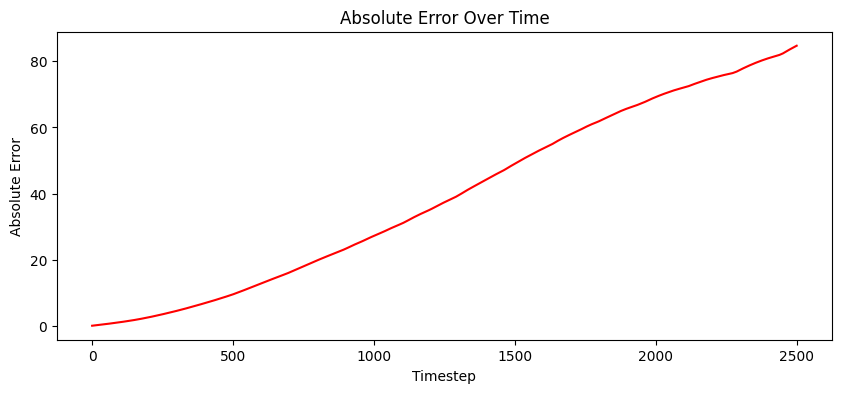

In [ ]:
plot_abs_error(diff_KS)

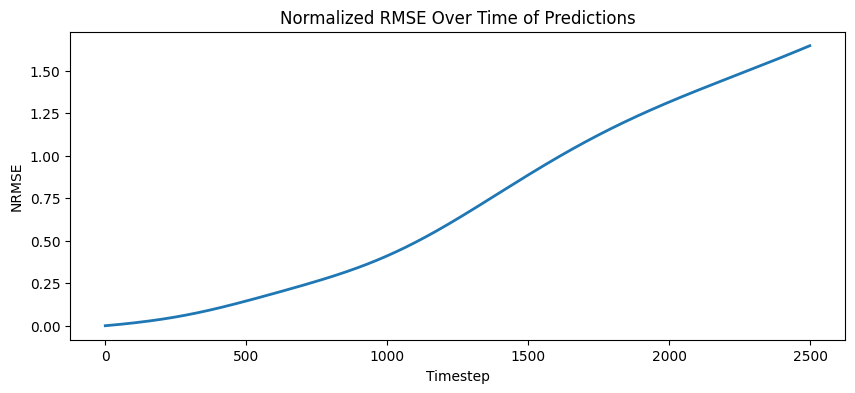

In [ ]:
plot_rmse(diff_KS, true_KS)

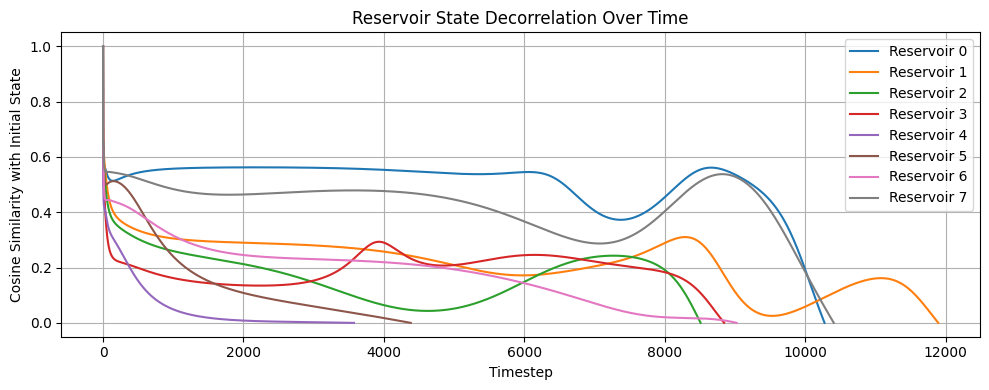

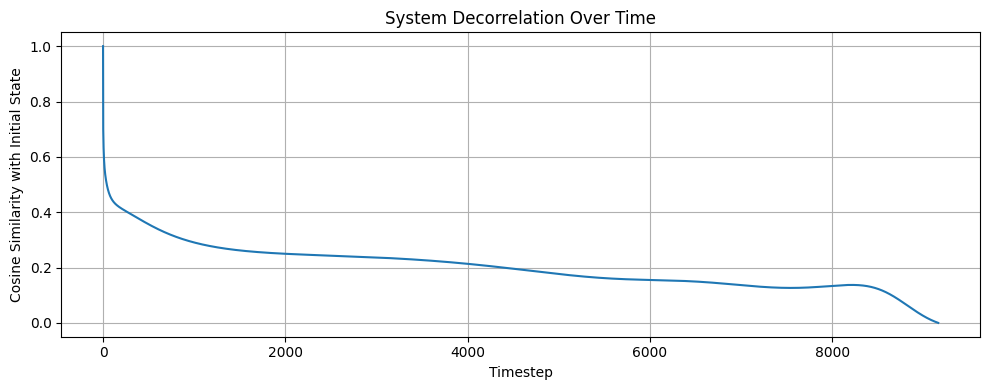

9162

In [ ]:
plot_decorrelation(combined_reservoirs_KS, 1)
plot_data_decorrelation(KS_data, 0)

# Evaluation Metrics

In [ ]:
# KS system parameters
training_time_KS = 10000
prediction_time_KS = 1000
t0_KS = 0; tf_KS = 75
# X_partitions   X_length
N = 64;           L = 22
# - - - - - - - - [R  C  D]
partitions_KS      = [8, 0, 0]
reservoir_size_KS  = 500
overlap_KS = 4

# Rossler system parameters
training_time_R = 20000
prediction_time_R = 250
t0_R = 0; tf_R = 500
a = 0.2; b = 0.2; c = 5.7
rossler_ic = [0.1, 0.1, 0.1]
# - - - - - - - - [R  C  D]
partitions_R      = [3, 0, 0]
reservoir_size_R  = 200
overlap_R = 2;

# Lorenz system parameters
training_time_L = 10000
prediction_time_L = 250
t0_L = 0; tf_L = 40
sigma = 10; rho = 28; beta = 8/3
lorenz_ic = [1.0, 1.0, 1.0]
# - - - - - - - - [R  C  D]
partitions_L      = [3, 0, 0]
reservoir_size_L  = 100
overlap_L = 2;

# DON'T CHANGE
enforced_max_eigenvalue = .58; input_weight_range = .01; ridge_beta = 0.0001

# ESN Parameters
degree     = 3
leaky_rate = 1
# DON'T CHANGE
enforced_max_eigenvalue = .58; input_weight_range = .01; ridge_beta = 0.0001

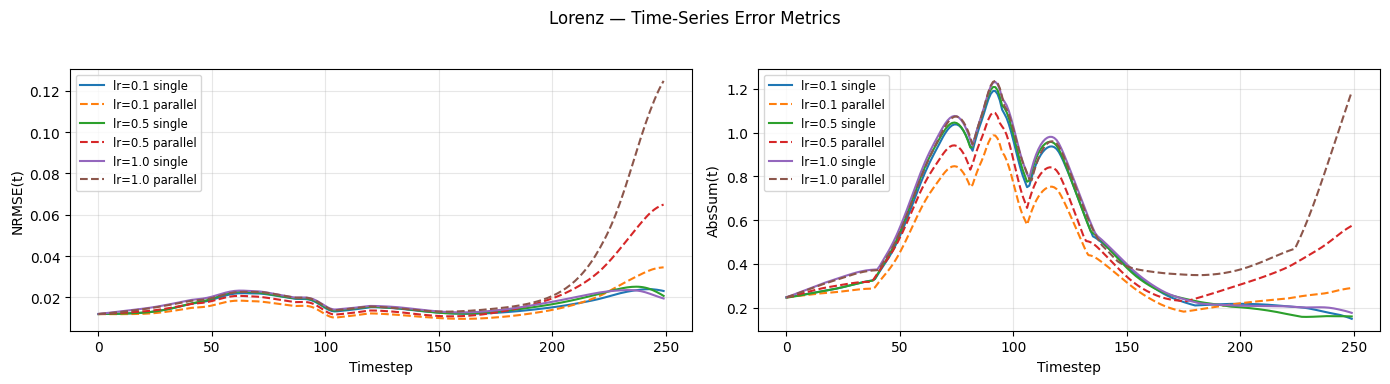

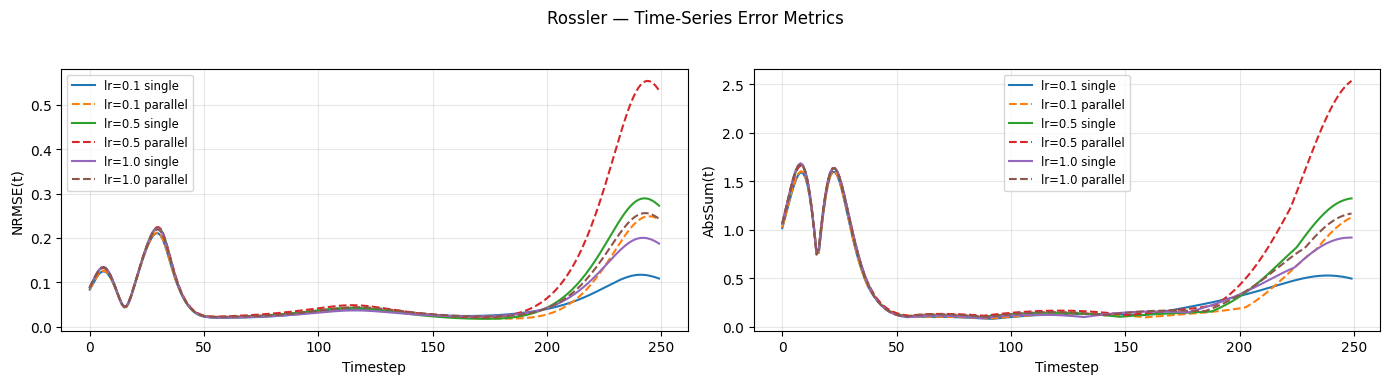

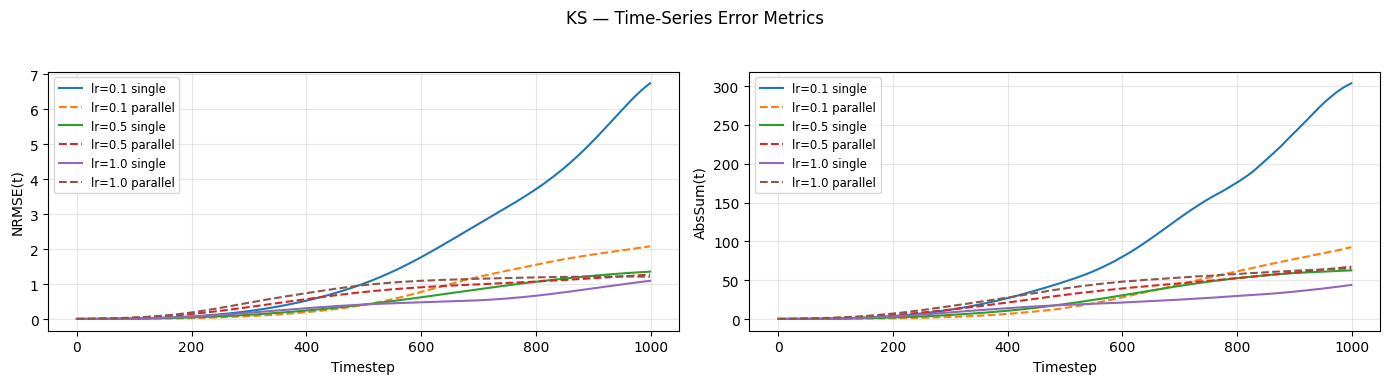

In [ ]:
# — make sure these are already in memory: —
# generate_lorenz_data, generate_rossler_data, ks (KuramotoSivashinsky instance)
# train_and_calculate, predict
# plus your globals: training_time, prediction_time, t0, tf,
# sigma, rho, beta, lorenz_ic, a, b, c, rossler_ic,
# reservoir_size, degree, enforced_max_eigenvalue,
# input_weight_range, overlap, ridge_beta

leaky_rates = [0.1, 0.5, 1.0]
systems     = ['Lorenz', 'Rossler', 'KS']

def run_prediction(system_name, lr, parts):
    # 1) Grab your existing data
    if system_name == 'Lorenz':

        training_time = training_time_L; prediction_time = prediction_time_L
        t0 = t0_L; tf = tf_L
        reservoir_size = reservoir_size_L; overlap = overlap_L


        U    = generate_lorenz_data(training_time, prediction_time, t0, tf,
                                     sigma, rho, beta, lorenz_ic)
        inp  = U[:, None, :-1]
        true = U[:,        training_time:training_time+prediction_time]

    elif system_name == 'Rossler':

        training_time = training_time_R; prediction_time = prediction_time_R
        t0 = t0_R; tf = tf_R
        reservoir_size = reservoir_size_R; overlap = overlap_R

        _, R = generate_rossler_data(training_time, prediction_time, t0, tf,
                                     a, b, c, rossler_ic)
        inp  = R.T[:, None, :-1]
        true = R.T[:,        training_time:training_time+prediction_time]

    elif system_name == 'KS':

        training_time = training_time_KS; prediction_time = prediction_time_KS
        t0 = t0_KS; tf = tf_KS
        reservoir_size = reservoir_size_KS; overlap = overlap_KS

        ks = KuramotoSivashinsky(training_time, prediction_time, t0, tf, N, L, mu=.01, lam=100)
        tt, KSdata = ks.solve(u0)
        inp        = KSdata.T[:, None, :-1]
        true       = KSdata.T[:,        training_time:training_time+prediction_time]

    # 2) Train
    Idim, Isize, Dsize, pSizes, Win, A, Rst, Din, rc, W1, W2 = \
        train_and_calculate(
            training_time, prediction_time, inp,
            reservoir_size, degree, lr,
            parts, enforced_max_eigenvalue,
            input_weight_range, overlap, ridge_beta
        )

    # 3) Predict
    pred, _ = predict(
        prediction_time,
        Idim, Isize, Dsize,
        parts, pSizes, Win, A, Rst,
        reservoir_size, Din, rc, overlap, lr, W1, W2
    )

    return true, pred.squeeze(axis=1)


for system_name in systems:
    fig, (ax_nr, ax_ab) = plt.subplots(1, 2, figsize=(14, 4))
    fig.suptitle(f"{system_name} — Time-Series Error Metrics")

    for lr in leaky_rates:
        true, ps = run_prediction(system_name, lr, [1,0,0])

        if system_name == 'KS':
            _,   pp = run_prediction(system_name, lr, [8,0,0])
        else:
            _,   pp = run_prediction(system_name, lr, [3,0,0])

        D, T = true.shape
        std_t = np.std(true, axis=0) + 1e-8

        # NRMSE(t)
        '''
        if single reservior, just use single call
        and if its parallel reserviour, just calculate nrmse and abs for all three call
        '''
        nrmse_s = np.sqrt(((ps-true)**2).mean(axis=0)) / std_t
        nrmse_p = np.sqrt(((pp-true)**2).mean(axis=0)) / std_t

        # AbsSum(t)
        abs_s = np.abs(ps-true).sum(axis=0)
        abs_p = np.abs(pp-true).sum(axis=0)

        ax_nr.plot(np.arange(T), nrmse_s,   '-', label=f"lr={lr} single")
        ax_nr.plot(np.arange(T), nrmse_p, '--', label=f"lr={lr} parallel")

        ax_ab.plot(np.arange(T), abs_s,   '-', label=f"lr={lr} single")
        ax_ab.plot(np.arange(T), abs_p, '--', label=f"lr={lr} parallel")

    ax_nr.set_xlabel("Timestep");     ax_nr.set_ylabel("NRMSE(t)")
    ax_nr.legend(fontsize="small");  ax_nr.grid(alpha=0.3)

    ax_ab.set_xlabel("Timestep");     ax_ab.set_ylabel("AbsSum(t)")
    ax_ab.legend(fontsize="small");  ax_ab.grid(alpha=0.3)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

def get_avg_cosine_decay(R, t0):
    # R shape: (n_reservoirs, n_dim, n_time)
    avg_sim = []
    for t in range(t0 + 1, R.shape[2]):
        sims = [cosine_similarity(R[i,:,t0], R[i,:,t]) for i in range(R.shape[0])]
        avg_sim.append(np.mean(sims))
    return np.array(avg_sim)

def plot_decorrelation(R_alpha_1, R_alpha_0_1, system_states, system_name):
    t0 = 0  # or wherever you want to start from
    model_1 = get_avg_cosine_decay(R_alpha_1, t0)
    model_01 = get_avg_cosine_decay(R_alpha_0_1, t0)

    system_curve = []
    for t in range(t0 + 1, system_states.shape[1]):
        sim = cosine_similarity(system_states[:,t0], system_states[:,t])
        system_curve.append(sim)

    plt.figure(figsize=(8, 5))
    plt.plot(model_1, label="Model α=1.0 avg")
    plt.plot(model_01, label="Model α=0.1 avg")
    plt.plot(system_curve, '--', label=f"{system_name} System")
    plt.title(f"{system_name} — Decorrelation Timescale")
    plt.xlabel("Timesteps")
    plt.ylabel("Cosine Similarity")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_decorrelation(R_lorenz_1, R_lorenz_01, lorenz_true_states, "Lorenz")
plot_decorrelation(R_rossler_1, R_rossler_01, rossler_true_states, "Rossler")
plot_decorrelation(R_ks_1, R_ks_01, ks_true_states, "KS")